In [1]:
import torch
from torch.optim import Adam

import pickle
import soundfile as sf
import IPython.display as ipd

from constants import *
from train import train_model
from early_stopper import EarlyStopper

from phase_loss import PhaseLoss
from magnitude_loss import MagnitudeLoss

from dataset import build_data_loaders
from disk_utils import save_model, load_model
from plotter import plot_loss, plot_heatmaps, plot_waves
from predict import predict_polar, get_phases, make_wav

from models.model_1 import Model_1
from models.sub_pix import UNetWithSubpixel

In [2]:
USE_GPU = True

num_epochs = 250
test_size = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not USE_GPU:
    device = torch.device("cpu")
    num_epochs = 1

In [3]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

# model = Model_1(features=64)
model = UNetWithSubpixel(features=32)
part = "db"
train_data_loader, test_data_loader = build_data_loaders(
    min_max, part=part, test_size=test_size)

mini = min_max["ney"]["min"][part]
maxi = min_max["ney"]["max"][part]


criterion = MagnitudeLoss(mini, maxi)
optimizer = Adam(model.parameters(), lr=2e-4)
es = EarlyStopper(10, 0)

In [4]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    device,
    train_data_loader, test_data_loader,
    es,
    num_epochs=num_epochs
)

Starting training...
E: 001/250	 T: 116.991067	 V: 49.466671
E: 002/250	 T: 33.232553	 V: 32.896483
E: 003/250	 T: 37.245143	 V: 33.561126
E: 004/250	 T: 28.938199	 V: 27.165798
E: 005/250	 T: 26.528193	 V: 25.727826
E: 006/250	 T: 25.317588	 V: 25.253201
E: 007/250	 T: 24.827945	 V: 26.877691
E: 008/250	 T: 23.808914	 V: 27.142655
E: 009/250	 T: 23.461637	 V: 27.407120
E: 010/250	 T: 23.162852	 V: 27.165680
E: 011/250	 T: 22.849292	 V: 26.849899
E: 012/250	 T: 22.664982	 V: 26.737532
E: 013/250	 T: 22.366496	 V: 25.636869
E: 014/250	 T: 22.088012	 V: 25.168582
E: 015/250	 T: 21.850309	 V: 24.553592
E: 016/250	 T: 21.662563	 V: 26.642732
E: 017/250	 T: 21.519072	 V: 26.279344
E: 018/250	 T: 21.331748	 V: 26.306922
E: 019/250	 T: 21.136949	 V: 26.420471
E: 020/250	 T: 21.511889	 V: 26.027270
E: 021/250	 T: 20.880539	 V: 26.981678
E: 022/250	 T: 20.714326	 V: 26.900055
E: 023/250	 T: 20.564677	 V: 27.269544
E: 024/250	 T: 20.433051	 V: 27.134644
E: 025/250	 T: 20.239827	 V: 26.311981
Sto

In [5]:
model.to(torch.device("cpu"))

UNetWithSubpixel(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=

In [14]:
del model
torch.cuda.empty_cache()

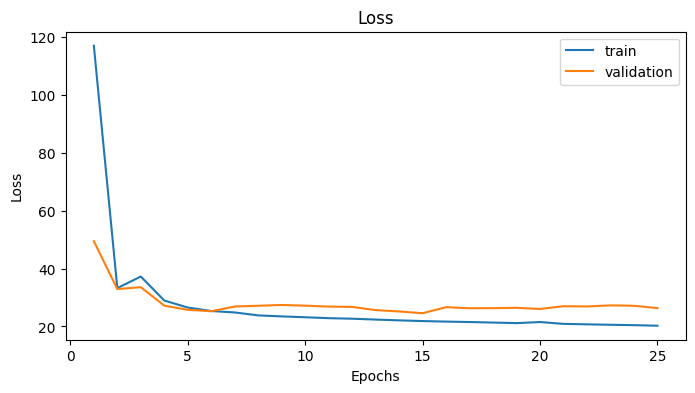

In [6]:
plot_loss(history, "Loss", start=0)

In [ ]:
model = load_model("model_19_mag")

In [4]:
pred_limit = 32
predictions, targets = predict_polar(
    model,
    test_data_loader,
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part],
    limit=pred_limit,
    from_db=(part == "db"))

Gtr_2_18/chunk_57, Gtr_1_05/chunk_39, Gtr_2_15/chunk_21, Gtr_2_18/chunk_29, Gtr_1_05/chunk_14, Gtr_1_05/chunk_30, Gtr_1_05/chunk_21, Gtr_2_26/chunk_33
Ney_2_18/chunk_57, Ney_1_05/chunk_39, Ney_2_15/chunk_21, Ney_2_18/chunk_29, Ney_1_05/chunk_14, Ney_1_05/chunk_30, Ney_1_05/chunk_21, Ney_2_26/chunk_33
--------------------------------------------------
Gtr_2_15/chunk_14, Gtr_2_26/chunk_50, Gtr_2_26/chunk_0, Gtr_2_15/chunk_59, Gtr_2_15/chunk_2, Gtr_2_15/chunk_36, Gtr_1_27/chunk_33, Gtr_1_05/chunk_11
Ney_2_15/chunk_14, Ney_2_26/chunk_50, Ney_2_26/chunk_0, Ney_2_15/chunk_59, Ney_2_15/chunk_2, Ney_2_15/chunk_36, Ney_1_27/chunk_33, Ney_1_05/chunk_11
--------------------------------------------------
Gtr_2_18/chunk_44, Gtr_1_05/chunk_60, Gtr_2_15/chunk_17, Gtr_2_15/chunk_60, Gtr_1_27/chunk_6, Gtr_1_05/chunk_26, Gtr_1_05/chunk_34, Gtr_2_26/chunk_26
Ney_2_18/chunk_44, Ney_2_05/chunk_60, Ney_2_15/chunk_17, Ney_2_15/chunk_60, Ney_1_27/chunk_6, Ney_2_05/chunk_26, Ney_1_05/chunk_34, Ney_2_26/chunk_2

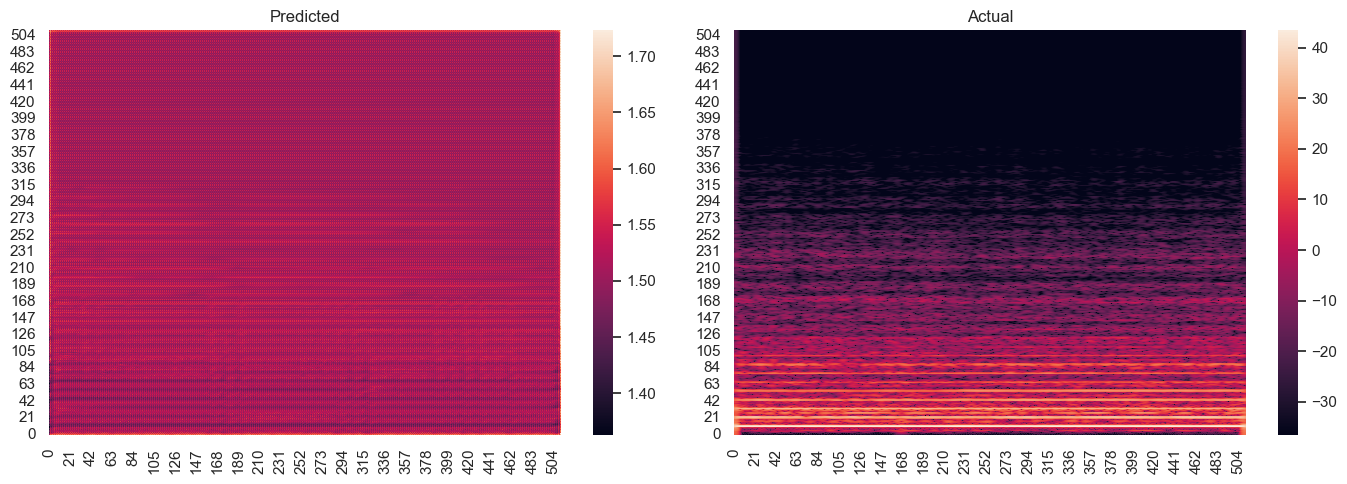

In [5]:
plot_heatmaps(predictions[0], targets[0], from_db=(part == "db"))

In [10]:
_, test_data_loader_phase = build_data_loaders(
    min_max, part="phase", test_size=test_size)
phases = get_phases(test_data_loader_phase,
                    instrument="ney",
                    limit=pred_limit)

Ney_2_18/chunk_32, Ney_2_18/chunk_45, Ney_2_18/chunk_38, Ney_2_18/chunk_53, Ney_2_18/chunk_3, Ney_1_27/chunk_35, Ney_2_18/chunk_19, Ney_1_05/chunk_18
--------------------------------------------------
Ney_2_15/chunk_44, Ney_1_05/chunk_52, Ney_1_27/chunk_55, Ney_2_15/chunk_34, Ney_2_05/chunk_25, Ney_2_05/chunk_47, Ney_2_26/chunk_51, Ney_2_15/chunk_24
--------------------------------------------------
Ney_2_26/chunk_30, Ney_2_15/chunk_30, Ney_2_05/chunk_14, Ney_1_05/chunk_29, Ney_2_15/chunk_3, Ney_1_05/chunk_11, Ney_1_27/chunk_13, Ney_1_05/chunk_2
--------------------------------------------------
Ney_2_26/chunk_44, Ney_2_18/chunk_2, Ney_2_15/chunk_50, Ney_1_05/chunk_47, Ney_1_05/chunk_28, Ney_2_15/chunk_60, Ney_2_26/chunk_42, Ney_2_26/chunk_24
--------------------------------------------------


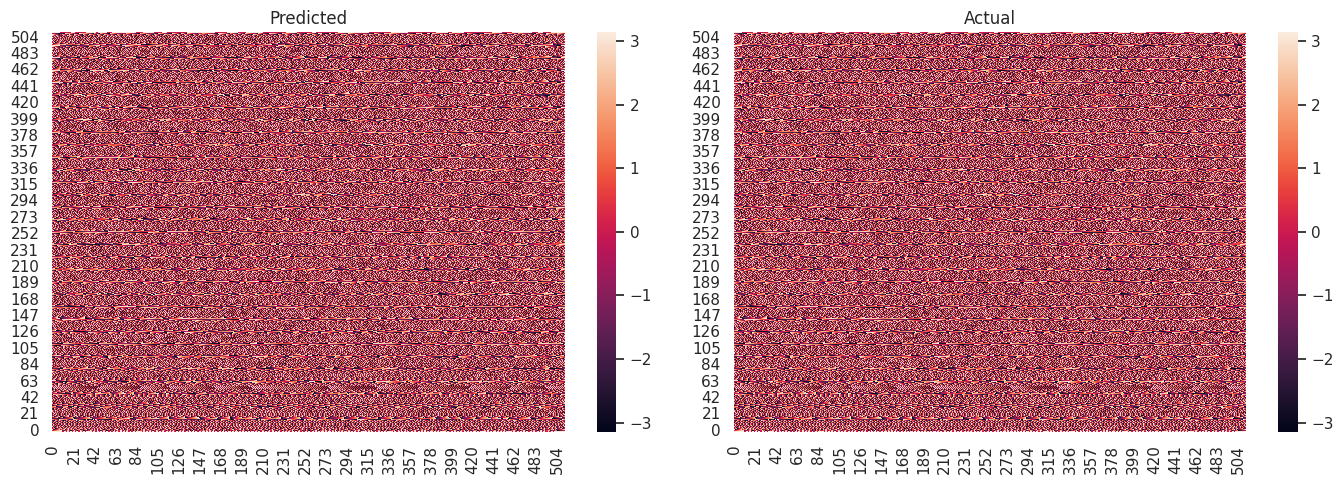

In [11]:
plot_heatmaps(phases[0], phases[0])

64448 64448


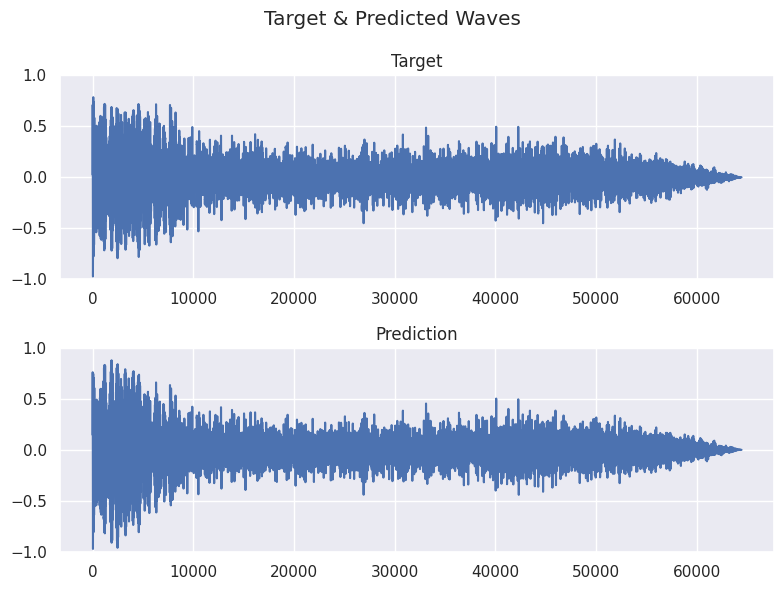

In [12]:
wave_prediction = make_wav(predictions, phases)
wave_target = make_wav(targets, phases)
print(len(wave_prediction), len(wave_target))
plot_waves(wave_target, wave_prediction)

In [ ]:
ipd.Audio(wave_target, rate=SR)

In [ ]:
ipd.Audio(wave_prediction, rate=SR)

In [12]:
sf.write("z_target_m1_64.wav", wave_target, SR, format="wav")
sf.write("z_prediction_m1_64.wav", wave_prediction, SR, format="wav")

In [4]:
save_model(model, "model_subpix_32")